In [1]:
import pandas as pd
import numpy as np
import math

import irc6_2007 as irc6

from Cross import Cross_section,cables, expansion_calc
from bridge_specs import box
from allinput import main_input

In [2]:
df=pd.read_excel('data/span.xlsx',index_col=None,header=None)
fck = 35 #input grade of concrete
span = int(df.iloc[2])
no = int(df.iloc[1])
sc=[(j)/(no-1)*50 for j in range(no)]

***required:***
1. list of sections with cable profile
2. BM due to permanent dead load
3. BM due to superimposed dead load (without surfacing)
4. BM due to surfacing
5. BM due to live load (max of all vehicle loads)

**defining sections**

main section

In [3]:

"""INPUTS SECTION"""

"""FOR CROSS SECTION"""
length=[]
height=[]


#####################################################################################################################

"""GUI INPUT OF BRIDGE SECTION LENGTHS AND HEIGHTS"""

if False:
    main_input()

df=pd.read_excel('data/box.xlsx',index_col=None,header=None)


height=df.values.tolist()[0]
length=df.values.tolist()[1]


section=Cross_section(length,height)
cable_no = 18 #input no of cables
cable = cables(fck,cable_no,section)

Generating intermediate sections

In [4]:
sections = []
for i in range(no):  
    section1=Cross_section(length,height)
    section1.expansion_width=expansion_calc(span,sc[i],cable)
    section1.cableprop=cable.cablepos(sc[i],50)
    sections.append(section1)

In [5]:
# endsec = sections[0]
# endsec.cable_prop

# midsec = sections[4]
# midsec.cable_prop, endsec.Centroid

**Importing load**

In [6]:
df = pd.read_excel('outputs/Moments.xlsx', index_col=0)

#bm multipied by distribution factor
bm_pdl = np.array(df['Dead Load'])
bm_odl = np.array(df['Other Loads'])
bm_surf = np.array(df['Surface Loads'])
bm_pedl = np.array(df['Pedestrian Load'])

dfl = pd.read_excel('outputs/loads.xlsx', index_col=[0, 1]) #live load

**live load calculation**

Impact factor

In [7]:
vehicles = [irc6.ll_A, irc6.ll_70R, irc6.ll_70RT]
IF = [irc6.impact(i.name, span) for i in vehicles]
arr_if = np.array(IF)
arr_with_if = np.array(IF)+1 #including impact factor

distribution factor

In [8]:
dfe = pd.read_excel('outputs/max_e.xlsx', index_col=0)

ecc = dfe['MaxEccentricity'] #eccentricity

def df(ecc, webcc):
    df = (webcc/2+ecc)/webcc
    return round(df, 3)

webcc = 3 #input web center/center distance
distf = [df(i, webcc) for i in ecc]
distf

[1.067, 0.5, 0.635, 0.617]

bm for ll combinations

In [9]:
arr_maxbm = dfl.loc['MaxBM'].to_numpy() # max bm due to each veh
arr_maxbmif = arr_maxbm*arr_with_if[:, np.newaxis] # max bm including impact due to ll

arr_ll_comb = dfe.drop(columns='MaxEccentricity').to_numpy() # ll combinations in array

all_ll = arr_ll_comb.dot(arr_maxbmif) # ll with impact for each combination
all_unfactored_ll = all_ll #without dist factor
# all_unfactored_ll = all_ll*np.array(distf)[:, np.newaxis] # distributed bm due to live load including impact (bm*if*df)

bm_ll = np.amax(all_unfactored_ll, axis=0)
bm_ll

array([    0.      ,  5250.7152  ,  8922.6336  , 11142.723712,
       12024.9024  , 11619.922688,  9417.0208  ,  5428.332288,
           0.      ])

### Cable profile

In [10]:
# def cable_profile(end_cable_pos, mid_cable_pos, span_length, division=8):
#     cable_profile = []
#     x = [(j)/division*span_length for j in range(division+1)]
#     for i in x:
#         cable_pos_x = []
#         for j in range(len(end_cable_pos)):
#             h = end_cable_pos[j][1]-mid_cable_pos[j][1]
#             a = end_cable_pos[j][1]
#             y = a + 4*h*i/span_length - 4*h*i**2/span_length**2
#             cable_pos_x.append((end_cable_pos[j][0], y))
#         cable_profile.append(cable_pos_x)
#     return cable_profile

### Eccentricity of cables

In [11]:
def eccentricity(cable_positions, centroid):
    cable_areaxpos_sum = 0
    for i in cable_positions:
        cable_areaxpos_sum+=(i[1]-centroid)
    return cable_areaxpos_sum/len(cable_positions)

### Stress

In [12]:
list_of_sections = sections
prestressing_force = 2730 #input
prestressing_force_total = prestressing_force*cable_no
# prestressing_force_withloss = 0.75*prestressing_force

In [13]:
def tau(section, bm):
    tau_top = bm*section.ymin/section.I[0]
    tau_bot = -bm*section.ymax/section.I[0]
    return (tau_top, tau_bot)

presetressing stress

In [14]:
#due to eccentricity
bm_pre = [prestressing_force_total*eccentricity(i.cableprop, i.Centroid[1]) for i in list_of_sections] #bm due to full prestressing force

list_tau_pre = [tau(list_of_sections[index], bm_pre[index]) for index in range(len(list_of_sections))] #stress due to full prestressing force

#axial
list_tau_ax = [prestressing_force_total/sum(i.section_area) for i in list_of_sections]

list_tau_preTotal = [(list_tau_pre[index][0] + list_tau_ax[index], list_tau_pre[index][1] + list_tau_ax[index]) for index in range(len(list_of_sections))]

In [15]:
list_tau_preTotal

[(3277.460536860909, 8675.468950377986),
 (2666.411895480194, 9782.54906396105),
 (2229.9485802082545, 10573.32057366324),
 (1968.0705910450924, 11047.783479484551),
 (1880.7779279907045, 11205.937781424991),
 (1968.0705910450924, 11047.783479484551),
 (2229.9485802082545, 10573.32057366324),
 (2666.411895480194, 9782.54906396105),
 (3277.460536860909, 8675.468950377986)]

stress due to ded load

In [16]:
list_tau_DL = [tau(list_of_sections[index], bm_pdl[index]) for index in range(len(list_of_sections))]

In [17]:
list_tau_DL

[(0.0, -0.0),
 (1724.830588940131, -3124.9977743190043),
 (2956.852438183081, -5357.139041689721),
 (3696.0655477288515, -6696.42380211215),
 (3942.4699175774413, -7142.852055586292),
 (3696.0655477288515, -6696.42380211215),
 (2956.852438183081, -5357.139041689721),
 (1724.830588940131, -3124.9977743190043),
 (0.0, -0.0)]

stress due to surfacing

In [18]:
list_tau_surf = [tau(list_of_sections[index], bm_surf[index]) for index in range(len(list_of_sections))]

In [19]:
list_tau_surf

[(0.0, -0.0),
 (75.57281477393754, -136.9206225132493),
 (129.5533967553215, -234.72106716557025),
 (161.94174594415185, -293.4013339569628),
 (172.73786234042865, -312.961422887427),
 (161.94174594415185, -293.4013339569628),
 (129.5533967553215, -234.72106716557025),
 (75.57281477393754, -136.9206225132493),
 (0.0, -0.0)]

stress due to other load

In [20]:
list_tau_ODL = [tau(list_of_sections[index], bm_odl[index]) for index in range(len(list_of_sections))]

In [21]:
list_tau_ODL

[(0.0, -0.0),
 (114.50426480899627, -207.45548865643835),
 (196.29302538685076, -355.6379805538943),
 (245.36628173356345, -444.54747569236787),
 (261.72403384913434, -474.18397407185904),
 (245.36628173356345, -444.54747569236787),
 (196.29302538685076, -355.6379805538943),
 (114.50426480899627, -207.45548865643835),
 (0.0, -0.0)]

stress due to live load

In [22]:
list_tau_LL = [tau(list_of_sections[index], bm_ll[index]) for index in range(len(list_of_sections))]

In [23]:
arr_stress_top = np.array([
    list(zip(*list_tau_DL))[0], 
    list(zip(*list_tau_ODL))[0], 
    list(zip(*list_tau_surf))[0], 
    list(zip(*list_tau_LL))[0], 
    list(zip(*list_tau_preTotal))[0]
])

arr_stress_bot = np.array([
    list(zip(*list_tau_DL))[1], 
    list(zip(*list_tau_ODL))[1], 
    list(zip(*list_tau_surf))[1], 
    list(zip(*list_tau_LL))[1], 
    list(zip(*list_tau_preTotal))[1]
])

**Case 1: Rare combination I**

RI = DL + PS@10%loss

In [24]:
psf_RI = np.array([1, 0, 0, 0, 0.9]) #partial safety factor [DL, ODL, surf, LL, Ps] irc:6-2007 table B3

tauTop_RI = psf_RI.dot(arr_stress_top) #resultant pressure top

tauBot_RI = psf_RI.dot(arr_stress_bot) #resultant pressure bottom

tauTop_RI, tauBot_RI

(array([2949.71448317, 4124.60129487, 4963.80616037, 5467.32907967,
        5635.17005277, 5467.32907967, 4963.80616037, 4124.60129487,
        2949.71448317]),
 array([7807.92205534, 5679.29638325, 4158.84947461, 3246.58132942,
        2942.4919477 , 3246.58132942, 4158.84947461, 5679.29638325,
        7807.92205534]))

Allowable stresses

In [25]:
tauTop_perm = -int(0.259*math.pow(fck, 2/3)*1000) #permissible stress on top (tensile) kN/m2

tauBot_perm = int(0.48*35*1000) #permissible stress on top (compression) kN/m2
tauTop_perm, tauBot_perm

(-2771, 16800)

check

In [26]:
if all(tauTop_RI>tauTop_perm) == True:
    print('top ok')
else:
    print('top not ok')
    
if all(tauBot_RI<tauBot_perm) == True:
    print('bottom ok')
else:
    print('bottom not ok')

top ok
bottom ok


**Case 2: Rare combination II**

RII = DL + ODL + 1.2*Surf + 0.75*LL + PS@25%loss

In [27]:
psf_RII = np.array([1, 1, 1.2, 0.75, 0.75]) #partial safety factor [DL, ODL, surf, LL, PS] irc:6-2007 table B3

tauTop_RII = psf_RII.dot(arr_stress_top) #resultant pressure top

tauBot_RII = psf_RII.dot(arr_stress_bot) #resultant pressure bottom

tauTop_RII, tauBot_RII

(array([2458.09540265, 4183.53669698, 5412.19731176, 6150.2121475 ,
        6403.08547151, 6173.26958276, 5436.08525248, 4192.11884973,
        2458.09540265]),
 array([6506.60171278, 3380.49748024, 1154.44599947, -182.66776341,
        -640.81627943, -224.44255237, 1111.16652491, 3364.94858609,
        6506.60171278]))

Allowable stresses

In [28]:
tauTop_perm = -int(0.259*math.pow(fck, 2/3)*1000) #permissible stress on top (tensile) kN/m2

tauBot_perm = int(0.36*35*1000) #permissible stress on top (compression) kN/m2
tauTop_perm, tauBot_perm

(-2771, 12600)

check

In [29]:
if all(tauTop_RII>tauTop_perm) == True:
    print('top ok')
else:
    print('top not ok')
    
if all(tauBot_RII<tauBot_perm) == True:
    print('bottom ok')
else:
    print('bottom not ok')

top ok
bottom ok


**Case 2: Rare combination II**

RII = DL + ODL + 1.2*Surf + LL + PS@25%loss

In [30]:
psf_RII = np.array([1, 1, 1.2, 1, 0.75]) #partial safety factor [DL, ODL, surf, LL, PS] irc:6-2007 table B3

tauTop_RII = psf_RII.dot(arr_stress_top) #resultant pressure top

tauBot_RII = psf_RII.dot(arr_stress_bot) #resultant pressure bottom

tauTop_RII, tauBot_RII

(array([2458.09540265, 4268.10521161, 5555.90609073, 6329.67790738,
        6596.7596846 , 6360.42115438, 5587.75667837, 4279.54808195,
        2458.09540265]),
 array([6506.60171278, 3227.27871099,  894.07862349, -507.81859491,
        -991.70957222, -563.51831352,  836.37265741, 3206.54685213,
        6506.60171278]))

Allowable stresses

In [31]:
tauTop_perm = -int(0.259*math.pow(fck, 2/3)*1000) #permissible stress on top (tensile) kN/m2

tauBot_perm = int(0.46*35*1000) #permissible stress on top (compression) kN/m2
tauTop_perm, tauBot_perm

(-2771, 16100)

check

In [32]:
if all(tauTop_RII>tauTop_perm) == True:
    print('top ok')
else:
    print('top not ok')
    
if all(tauBot_RII<tauBot_perm) == True:
    print('bottom ok')
else:
    print('bottom not ok')

top ok
bottom ok


**Case 3: Permanent combination**

RII = DL + ODL + 1.2*Surf + 0.75*LL + PS@25%loss

In [33]:
psf_P = np.array([1, 1, 1.2, 0.75, 0.75]) #partial safety factor [DL, ODL, surf, LL, PS] irc:6-2007 table B3

tauTop_P = psf_P.dot(arr_stress_top) #resultant pressure top

tauBot_P = psf_P.dot(arr_stress_bot) #resultant pressure bottom

tauTop_P, tauBot_P

(array([2458.09540265, 4183.53669698, 5412.19731176, 6150.2121475 ,
        6403.08547151, 6173.26958276, 5436.08525248, 4192.11884973,
        2458.09540265]),
 array([6506.60171278, 3380.49748024, 1154.44599947, -182.66776341,
        -640.81627943, -224.44255237, 1111.16652491, 3364.94858609,
        6506.60171278]))

Allowable stresses

In [34]:
tauTop_perm = -int(0.259*math.pow(fck, 2/3)*1000) #permissible stress on top (tensile) kN/m2

tauBot_perm = int(0.36*35*1000) #permissible stress on top (compression) kN/m2
tauTop_perm, tauBot_perm

(-2771, 12600)

check

In [35]:
if all(tauTop_P>tauTop_perm) == True:
    print('top ok')
else:
    print('top not ok')
    
if all(tauBot_P<tauBot_perm) == True:
    print('bottom ok')
else:
    print('bottom not ok')

top ok
bottom ok


**Case 4: Quasi-Permanent**

QP = DL + ODL + PS@25%loss

In [36]:
psf_QP = np.array([1, 1, 0, 0, 0.75]) #partial safety factor [DL, ODL, surf, LL, PS] irc:6-2007 table B3

tauTop_QP = psf_QP.dot(arr_stress_top) #resultant pressure top

tauBot_QP = psf_QP.dot(arr_stress_bot) #resultant pressure bottom

tauTop_QP, tauBot_QP

(array([2458.09540265, 3839.14377536, 4825.60689873, 5417.48477275,
        5614.77739742, 5417.48477275, 4825.60689873, 3839.14377536,
        2458.09540265]),
 array([6506.60171278, 4004.458535  , 2217.213408  , 1144.86633181,
         787.41730641, 1144.86633181, 2217.213408  , 4004.458535  ,
        6506.60171278]))

Allowable stresses

In [37]:
tauTop_perm = -int(0.259*math.pow(fck, 2/3)*1000) #permissible stress on top (tensile) kN/m2

tauBot_perm = int(0.36*35*1000) #permissible stress on top (compression) kN/m2
tauTop_perm, tauBot_perm

(-2771, 12600)

check

In [38]:
if all(tauTop_QP>tauTop_perm) == True:
    print('top ok')
else:
    print('top not ok')
    
if all(tauBot_QP<tauBot_perm) == True:
    print('bottom ok')
else:
    print('bottom not ok')

top ok
bottom ok


In [39]:
tauTop_QP, tauBot_QP

(array([2458.09540265, 3839.14377536, 4825.60689873, 5417.48477275,
        5614.77739742, 5417.48477275, 4825.60689873, 3839.14377536,
        2458.09540265]),
 array([6506.60171278, 4004.458535  , 2217.213408  , 1144.86633181,
         787.41730641, 1144.86633181, 2217.213408  , 4004.458535  ,
        6506.60171278]))

In [40]:
endposabs = cable.endcablepos

In [41]:
import matplotlib.pyplot as plt

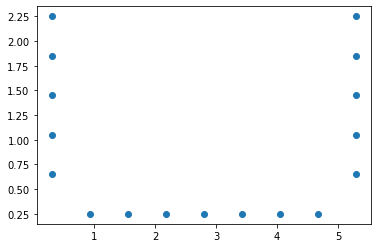

In [42]:
plt.scatter([i[0] for i in endposabs], [i[1] for i in endposabs])

0.625